In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

## Import data

In [3]:
VABB = pd.read_csv("data/cleaning/VABB_books_isbn_level.csv", dtype={"isbn":"str"})
VABB = VABB[["isbn","VABB_pubyear"]].copy()

In [6]:
# import the UniCat data
con_uc = sqlite3.connect("unicat_holdings.db")

holding_uc = pd.read_sql("""SELECT i.isbn, h.work_id, COUNT(distinct location) holding_count_uc
                        FROM holding h
                        JOIN isbn_search i ON h.work_id = i.work_id
                        GROUP BY i.isbn""", con_uc)

In [7]:
# import the Cultuurconnect data
con_cc = sqlite3.connect("cultuurconnect.db")

holding_cc = pd.read_sql("""SELECT i.isbn, h.frabl, COUNT(distinct library) holding_count_cc
            FROM holding h
            JOIN isbns i ON h.frabl = i.frabl
            GROUP BY i.isbn""", con_cc)

## Cleaning

In [8]:
# there are many publications where multiple publication years are mentiones (e.g because of editions)
VABB.VABB_pubyear.unique()

array(['2017', '2005', '2001', '2003', '2006', '2007', '2004', '2008',
       '2013', '2014', '2015', '2019', '2000', '2018', '2010',
       '2006;2005', '2015;2014;2001', '2002', '2003;2002', '2009;2010',
       '2008;2010', '2009', '2012', '2014;2017;2015', '2011;2012', '2011',
       '2014;2013', '2016', '2016;2017', '2003;2001',
       '2017;2019;2016;2018', '2019;2017', '2019;2018', '2020',
       '2003;2004', '2012;2013', '2014;2015', '2016;2015', '2018;2017',
       '2006;2005;2004', '2008;2002', '2005;2004', '2008;2006',
       '2008;2012', '2019;2015', '2016;2014', '2008;2009', '2013;2015',
       '2017;2015', '2019;2016', '2014;2018', '2011;2010', '2009;2000',
       '2005;2002', '2003;2013', '2008;2004', '2007;2000', '2012;2011',
       '2008;2003;2009', '2007;2001', '2001;2002', '2009;2006',
       '2008;2015', '2008;2001', '2009;2011', '2012;2013;2015',
       '2016;2014;2015', '2007;2006', '2014;2010', '2011;2013',
       '2013;2017', '2007;2003;2006', '2016;2013', '2009;

In [9]:
VABB.VABB_pubyear = VABB.VABB_pubyear.str.split(";").copy()
VABB.VABB_pubyear = VABB.VABB_pubyear.apply(set).copy()
VABB.VABB_pubyear = VABB.VABB_pubyear.apply(list)
VABB.VABB_pubyear = VABB.VABB_pubyear.apply(lambda x: sorted(x)) # sort the publication years

In [10]:
#only retain the earliest publication date
VABB["pubyear"] = VABB_pubyear = VABB.VABB_pubyear.apply(lambda x: x[0])

## Add UniCat and Cultuurconnect

In [11]:
df = VABB.merge(holding_uc, on="isbn", how="outer")

In [12]:
df = df.merge(holding_cc, on="isbn", how="outer")

In [13]:
df = df.fillna(0).copy()

In [14]:
df["inCC"] = df.holding_count_cc.apply(lambda x: True if x>0 else False)

In [15]:
df["inUC"] = df.holding_count_uc.apply(lambda x: True if x>0 else False)

In [16]:
df.pubyear = df.pubyear.astype(int)

In [17]:
df = df[df.pubyear < 2019]

## Visualize

In [18]:
VABB_years = pd.DataFrame(df.groupby("pubyear").isbn.count()).reset_index().rename(columns={"isbn":"count"})

In [19]:
CC = df[df.inCC == True]

In [20]:
CC_years = pd.DataFrame(CC.groupby("pubyear").isbn.count()).reset_index().rename(columns={"isbn":"count"})

In [21]:
UC = df[df.inUC == True]
UC_years = pd.DataFrame(UC.groupby("pubyear").isbn.count()).reset_index().rename(columns={"isbn":"count"})

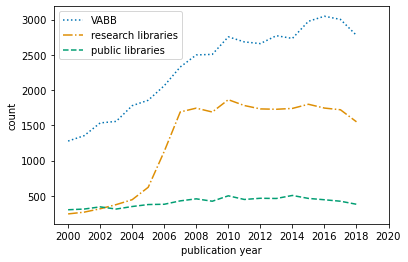

In [29]:
fig, ax = plt.subplots()

data = VABB_years

sns.color_palette("colorblind")

sns.lineplot(data=VABB_years, x ="pubyear", y = "count",label="VABB", linestyle = "dotted", ax=ax)
sns.lineplot(data = UC_years, x ="pubyear", y="count", label="research libraries", linestyle = "dashdot", ax=ax)
sns.lineplot(data = CC_years, x ="pubyear", y="count", label="public libraries", linestyle = "dashed", ax=ax)


ax.set_xlabel("publication year")
plt.xticks(range(2000,2021,2))

plt.savefig("plots/publication_years_colorblind.png")